# **TP1 - Exercicio 2 - Grupo 11**

Bruno Miguel Fernandes Araújo - A97509

Tiago Emanuel Lemos Teixeira - A97666

# **Exercicio 2 - Sistema de Tráfego**

2. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .O grafo tem de ser ligado: entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$

    1. Gerar aleatoriamente o grafo com  $N \in\{8..15\}$  nodos e com ramos verificando:
    
        1. Cada nodo tem um número aleatório de descendentes $d\in\{0 .. 3\}\$ cujos destinos são também gerados aleatoriamente. 
        
        2. Se  existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
        
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.
 

## **Gerar o grafo**

Para gerar o grafo sobre estas condições , foram criadas 3 funções auxiliares:

1. **gerar_grafo**: Esta função recebe um $N \in\{8..15\}$ e irá criar um grafo com N nodos em que os quais terão $d\in\{0 .. 3\}\$ descendentes, estes são decididos aleatóriamente graças á biblioteca random. Além disto, a função contém um if que refere-se á condição que indica que destinos repetidos, devem gerar outro grafo (Se um nodo ja tiver uma aresta/ramo com o destino gerado, é logo retornado um arrray vazio).

2. **loops**: Esta função devolve true ou false caso o grafo recebido tenha um loop ou não, respetivamente.

3. **desligado**: Esta função devolve false ou true caso o grafo recebido seja ou não ligado,respetivamente.

É de notar que na criação de um novo grafo, caso este não seja ligado, tenha loops ou tenha destinos repetidos, é gerado um novo grafo, este efeito é obtido usando um while por exemplo, da seguinte forma:

$N = random.randint(8,15)
grafo = gerar_grafo(N)
while grafo==[] or loops(grafo) or desligado(grafo):
  #N = random.randint(8,15)
  grafo = gerar_grafo(N)$
  
(grafo == [] - destinos repetidos presentes no grafo)

(loops(grafo) - loops presentes no grafo)

(desligado(grafo) - o grafo não se encontra ligado)



In [32]:
import networkx as nx
from z3 import *
import random
from ortools.linear_solver import pywraplp

#Função que gera o grafo
def gerar_grafo(N):
    
  grafo = nx.DiGraph()
  nodos = [i for i in range(N)]
  grafo.add_nodes_from(nodos)

  for origem in range(N):
   descendentes = random.randint(0,3)

   for i in range(descendentes+1):
    indice = random.randint(0,len(nodos)-1)
    
    #print((origem,indice))
    
    if(origem,indice) in grafo.edges:
      return []
    destino = nodos[indice]
    grafo.add_edge(origem,destino)
    
    #print(grafo.edges)
    
  return grafo
    
#Função que verifica a presença de loops no grafo    
def loops(graf):

    for aresta in graf.edges:
        origem,destino =aresta
        if origem == destino :
            return True
    return False

#Fução que verifica se o grafo não está ligado
def desligado(graf):
    nodes=[n for n in grafo.nodes()]
    origem=nodes[0]
    nodes.remove(0)
    for destino in nodes:
        if not(nx.has_path(graf,origem,destino) and nx.has_path(graf,destino,origem)) :
            return True
    return False

#Exemplo que verifica a funcionalidade da função loops e desligado

#graforep=nx.DiGraph()
#graforep.add_nodes_from([0,1,2,3])
#graforep.add_edge(0,1)
#graforep.add_edge(1,0)
#graforep.add_edge(0,2)
#graforep.add_edge(2,0)
#graforep.add_edge(0,3)
#graforep.add_edge(3,0)
#graforep.add_edge(2,3)
#graforep.add_edge(0,0)
#desligado(graforep)
#print(graforep.edges.data())
#print(nx.has_path(graforep,1,0))
#loops(graforep)
#nx.draw(graforep, pos = nx.shell_layout(graforep) ,with_labels=True, node_size=400)

## Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

A função **remove_max_vias**  tratará de remover o maior número de vias possiveis mantendo o grafo ligado.

Usa **um solver SCIP** e **dois dicionários**:

**Aresta**: Terá como chave a origem e destino das arestas do grafo num tuplo e como valor 1 ou 0 vindo do solver.
(Se solver obtiver uma solução , 1 será para as arestas que vão se manter presentes no grafo e 0 para aquelas que serão removidas)

**Caminho**: Terá como chave um triplo que contém a origem e destino das arestas juntamente com um caminho i que as liga e como valor 1 ou 0 vindo do solver.
(1 indica que existe um caminho da origem para o destino através do caminho i e 0 se este não existir).

Além disso são usados **dois arrays** importantes , **nodes** que contém todos do grafo exceto o primeiro e **paths** que contém todos os caminhos simples possiveis entre dois nodos.

## Restrições

Não pode existir um caminho do primeiro nodo para o destino se alguma aresta do conjunto das arestas do grafo não existir,consequentemente o valor de $Aresta_{e}$, em que $\mbox{e=o,d}$ (o=primeiro nodo e d=destino) nunca será menor que o valor de $Caminho_{o,d,i}$.

$$\forall_{d \in nodes,\ 0 \leq i < n,\ e \in paths_{o,d}[i]} \cdot Caminho_{o, d, i} \leq Aresta_{e} \mbox{, onde } n = \mbox{len}(paths)\mbox{ e o=nodes[0]}$$

Existir pelo menos um caminho entre $\mbox{o}$ e $\mbox{d}$.

$$\sum_{0 \leq i < n} Caminho_{o,d,i} \geq 1 \mbox{, onde } n = \mbox{len}(paths)$$

Desta forma garantimos que existe um caminho de $\mbox{o}$ para todos os outros.

Usamos o mesmo raciocinio mas desta vez de todos os nodos para $\mbox{o}$.

$$\forall_{d \in nodes,\ 0 \leq i < n,\ e \in paths_{d,o}[i]} \cdot Caminho_{d, o, i} \leq Aresta_{e} \mbox{, onde } n = \mbox{len}(paths)\mbox{ e o=nodes[0]}$$

$$\sum_{0 \leq i < n} Caminho_{d,o,i} \geq 1 \mbox{, onde } n = \mbox{len}(paths)$$

Assim garantimos que existe um caminho dos outros nodos para  $\mbox{o}$.

Por fim para obtermos o maior numero de vias que é possível remover , maximizamos o numero de arestas removidas.
$$\sum_{o,d \in A} Arestas_{o,d} \mbox{, onde A=grafo.edges}$$.


In [35]:
def remove_max_vias(grafo):
    
    solver = pywraplp.Solver.CreateSolver('SCIP')
    Aresta = {}
    narestas=len(grafo.edges)
    
    for origem,destino in grafo.edges():
        Aresta[(origem,destino)] = solver.BoolVar('A({origem},{destino}')
    
    nodes = [n for n in grafo.nodes()]
    
    o = nodes[0]
    
    nodes.remove(0)
    
    Caminho = {}
    
    #o é o primeiro nodo
    
    for d in nodes:
        
        #garantir que há caminho do primeiro nodo para todos os outros
        
        paths = list(nx.all_simple_edge_paths(grafo, o, d))
        N = len(paths)
        for i in range(N):
            Caminho[(o,d,i)] = solver.BoolVar('Caminho({o},{d},{i}')
            for edge in paths[i]:
                solver.Add(Caminho[(o,d,i)] <= Aresta[edge])
        solver.Add(sum([Caminho[(o,d,i)] for i in range(N)])>=1)
        
        #garantir que ha caminho do todos os outros nodos até o primeiro nodo
        
        paths = list(nx.all_simple_edge_paths(grafo, d, o))
        N = len(paths)
        for i in range(N):
            Caminho[(d,o,i)] = solver.BoolVar('Caminho({d},{o},{i}')
            for edge in paths[i]:
                solver.Add(Caminho[(d,o,i)] <= Aresta[edge])
        solver.Add(sum([Caminho[(d,o,i)] for i in range(N)])>=1)
            
        
    
    #Maximizar o numero de arestas removidas
    solver.Maximize(sum([1 - Aresta[(origem,destino)] for origem,destino in grafo.edges()]))
    
    #Remover as arestas
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        for origem,destino in Aresta:
            if Aresta[(origem,destino)].solution_value() == 0:
                grafo.remove_edge(origem,destino)
        print("Foram removidas " + str(narestas-len(grafo.edges())) + " arestas.")
    else:
        print("Sem solução")

# **Exemplos:**


DiGraph with 8 nodes and 18 edges
[(0, 7), (0, 6), (0, 4), (0, 3), (1, 0), (1, 5), (1, 3), (2, 6), (2, 0), (2, 3), (3, 2), (3, 4), (3, 0), (4, 3), (4, 2), (5, 1), (6, 5), (7, 0)]


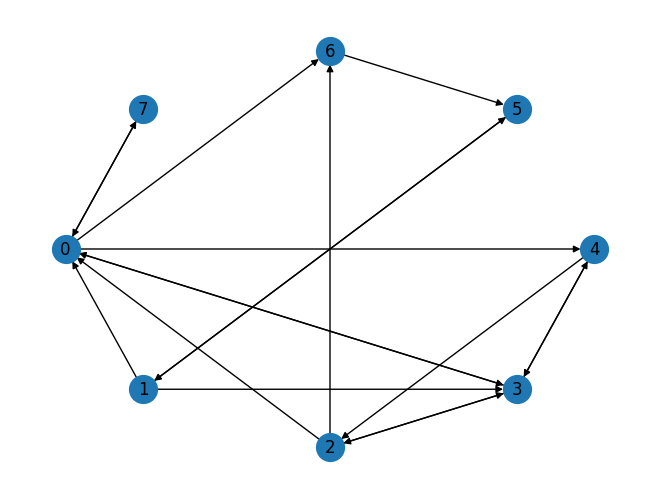

In [43]:
N = random.randint(8,15)
grafo = gerar_grafo(N)

while grafo==[] or loops(grafo) or desligado(grafo):
#  N = random.randint(8,15)
  grafo = gerar_grafo(N)
    
print(grafo)
print(grafo.edges)
nx.draw(grafo, pos = nx.shell_layout(grafo) ,with_labels=True, node_size=400)

Foram removidas 9 arestas.


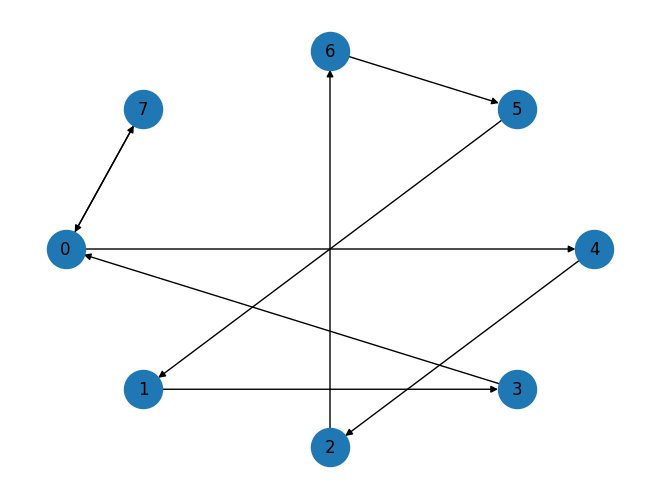

In [44]:
remove_max_vias(grafo)
nx.draw(grafo,pos = nx.shell_layout(grafo), with_labels=True, node_size=750)

DiGraph with 11 nodes and 19 edges
[(0, 8), (0, 10), (0, 2), (0, 4), (1, 0), (2, 6), (2, 0), (2, 8), (3, 10), (4, 5), (4, 1), (5, 0), (6, 3), (7, 9), (8, 7), (8, 5), (8, 6), (9, 6), (10, 1)]


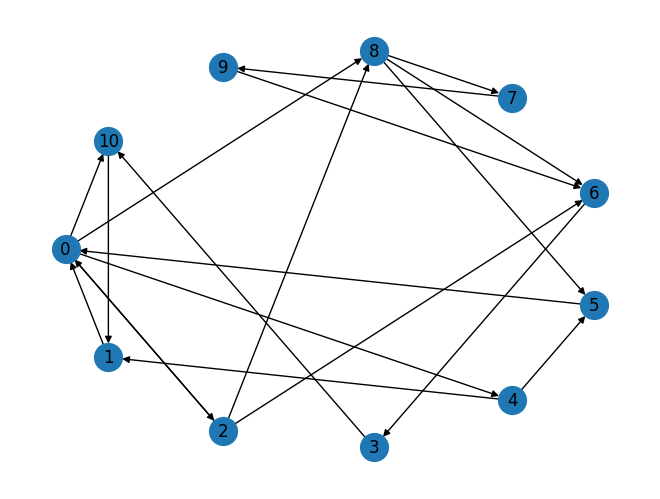

In [45]:
N = random.randint(8,15)
grafo = gerar_grafo(N)

while grafo==[] or loops(grafo) or desligado(grafo):
#  N = random.randint(8,15)
  grafo = gerar_grafo(N)
    
print(grafo)
print(grafo.edges)
nx.draw(grafo, pos = nx.shell_layout(grafo) ,with_labels=True, node_size=400)

Foram removidas 7 arestas.


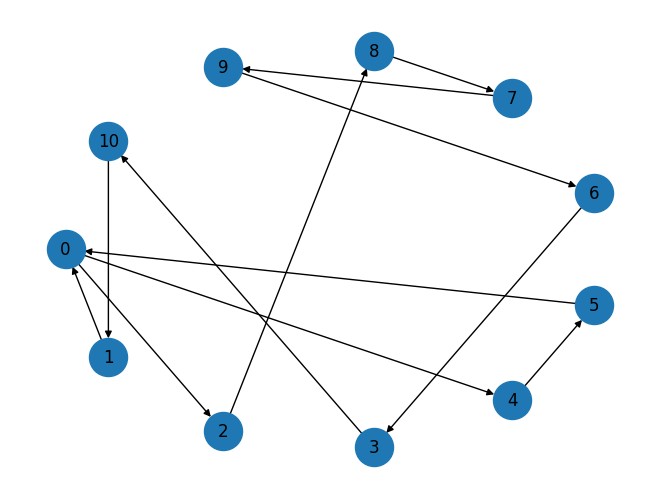

In [46]:
remove_max_vias(grafo)
nx.draw(grafo,pos = nx.shell_layout(grafo), with_labels=True, node_size=750)